# IBM Data Science Professional Certificate 

# Capstone Project - The Battle of Neighborhoods

# *Where to open a gym in London, England ?*

It is becoming increasingly trendy and popular to go to the gym. The benefits on health and shape are great and it is a good solution for people who don't have much time to spend for leisure. Indeed, people often go to gyms that are close to their home. In this capstone project, we will explore the neighborhoods of London in order to decide where are the best places to open a gym or a fitness center (which is often larger than a gym and provides more services). 


**Table of Contents**:

- Importing libraries
- Collecting & wrangling data
- Exploring data
- Machine Learning algorithm 
- Results 

## Importing libraries

The following libraries will be useful for this project.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

## Collecting & wrangling data

We will use the technique of *web scraping* to collect the list of neighborhoods of London. For that, we will scrap data from a wikipedia page referencing a list of areas in London. 

In [287]:
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
wiki_page = requests.get(url)

df = pd.read_html(wiki_page.content, header = 0)[1]
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [288]:
print("There are {} neighborhoods in Greater London.".format(df.shape[0]))

There are 533 neighborhoods in Greater London.


Let's note that the previous dataframe takes into account all the neighborhoods of the greater London, which consists of London and its suburbs. For our study, we will **only consider the neighborhoods inside London**. 

In [289]:
df = df[df['Post town']=='LONDON']
df.reset_index(inplace = True)
df.head()

,index,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,6,Aldgate,City[10],LONDON,EC3,020,TQ334813
3,7,Aldwych,Westminster[10],LONDON,WC2,020,TQ307810
4,9,Anerley,Bromley[11],LONDON,SE20,020,TQ345695


In [290]:
print("There are {} neighborhoods in London.".format(df.shape[0]))

There are 299 neighborhoods in London.


In [291]:
#The spaces between words in column names caused me troubles because I had a "Key error". It seems that the blank space is not always recognized as one. 
print(df.columns.tolist())

['index', 'Location', 'London\xa0borough', 'Post town', 'Postcode\xa0district', 'Dial\xa0code', 'OS grid ref']


Now that we know that all the neighborhoods are in London, we don't need the 'Post town' attribute anymore. The three last columns are not useful for our study as well so we will get rid of them. 

In [292]:
df.drop(["index", "Post town", "Postcode\xa0district", "Dial\xa0code", "OS grid ref"], axis=1, inplace=True)

In [293]:
df.head()

,Location,London borough
0,Abbey Wood,"Bexley, Greenwich [7]"
1,Acton,"Ealing, Hammersmith and Fulham[8]"
2,Aldgate,City[10]
3,Aldwych,Westminster[10]
4,Anerley,Bromley[11]


We now need to retrieve the geographical coordinates of each of these locations. This step is necessary to then use the Foursquare API in order to get the venues for each neighborhood. For that, we will use the geocoder library. 

But before, we need to rename the locations that contain parenthesis  because they can't be understood by geocoder. If we scroll through the dataframe, we can see that there are 3 locations in this situation. 

In [294]:
print("The 3 locations are:")
print(df['Location'][33])
print(df['Location'][164])
print(df['Location'][250])

df['Location'][33]= 'Bromley'
df['Location'][164]= 'Marylebone'
df['Location'][250]= 'Sydenham'

print("\n ...Locations updated!")

The 3 locations are:
Bromley (also Bromley-by-Bow)
Marylebone (also St Marylebone)
Sydenham (also Lower Sydenham, Upper Sydenham)

 ...Locations updated!


In [81]:
geolocator = Nominatim(user_agent="london_explorer")
Latitude = []
Longitude = []

for address in df["Location"]:
    if type(address) == 'NoneType': 
        pass
    else:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        Latitude.append(latitude)
        Longitude.append(longitude)
    


In [295]:
#We create a dataframe containing the positions and the geographical coordinates.
future_df = []
for i in range(len(Latitude)):
    future_df.append([df['Location'][i], Latitude[i], Longitude[i]])

df_geo = pd.DataFrame(future_df, columns = ['Location', 'Latitude', 'Longitude'])
print("The shape of df_geo is:", df_geo.shape)
df_geo.head()

The shape of df_geo is: (299, 3)


,Location,Latitude,Longitude
0,Abbey Wood,51.487621,0.114050
1,Acton,51.508140,-0.273261
2,Aldgate,51.514248,-0.075719
3,Aldwych,52.928619,-1.520567
4,Anerley,51.407599,-0.061939


Merging the two tables: 

In [296]:
df = df.join(df_geo.set_index('Location'), on='Location')

In [297]:
#Visualizing the new dataframe 
df.head()

,Location,London borough,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich [7]",51.487621,0.114050
1,Acton,"Ealing, Hammersmith and Fulham[8]",51.508140,-0.273261
2,Aldgate,City[10],51.514248,-0.075719
3,Aldwych,Westminster[10],52.928619,-1.520567
4,Anerley,Bromley[11],51.407599,-0.061939


In [298]:
# Also, let's delete duplicate lines. 
df.drop_duplicates(subset ="Location", keep = False, inplace = True) 
print(df.shape)

(295, 4)


In [300]:
# We reset the index because it was modified due to the removed duplicate lines. 
df.reset_index(inplace=True)
df.head()

,level_0,index,Location,London borough,Latitude,Longitude
0,0,0,Abbey Wood,"Bexley, Greenwich [7]",51.487621,0.114050
1,1,1,Acton,"Ealing, Hammersmith and Fulham[8]",51.508140,-0.273261
2,2,2,Aldgate,City[10],51.514248,-0.075719
3,3,3,Aldwych,Westminster[10],52.928619,-1.520567
4,4,4,Anerley,Bromley[11],51.407599,-0.061939


Let's first visualize the various neighborhoods with a Folium map. We must at least check that the locations are in London. 

In [301]:
# First, we must get the geographical coordinates of London to center the map. 

address = 'London'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are : {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are : 51.5073219, -0.1276474.


In [235]:
# Creating the folium map

import folium 

map_London = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Location']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_London)  
    
map_London

We clearly see that some locations have been incorrectly positionned by geolocator. It may be because the name exists in other parts of the world. Indeed, we note that the wrongly assigned locations have mainly been placed in other parts of the Uited Kingdoms or in the United States. 

We will get rid of these errors by only keeping the locations in London after defining conditions on the longitude and latitude. For that, we use the blue points that are at the borders of London. 
- West side : Hanwell
- East side : Crossness
- South side : Selhurst
- North side : Oakleigh Park

In [302]:
#Let's get the longitudes of Hanwell and Crossness, and the latitudes of Selhurst and Oakleigh Park. 

west_limit = df['Longitude'][113]
east_limit = df['Longitude'][64]
north_limit = df['Latitude'][185]
south_limit = df['Latitude'][209]

# In the dataframe, we only keep the locations that are in London: 
list_1 = []
for i in range(len(df['Longitude'])):
    #print(df['Location'][i])
    if west_limit<=df['Longitude'][i]<=east_limit:
        if south_limit<=df['Latitude'][i]<=north_limit:
            list_1.append([df['Location'][i],df['London\xa0borough'][i],df['Latitude'][i],df['Longitude'][i]])
                         
df = pd.DataFrame(list_1, columns=['Location', 'London borough', 'Latitude', 'Longitude'])
print(df.shape)
df.head()

(252, 4)


,Location,London borough,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich [7]",51.487621,0.114050
1,Acton,"Ealing, Hammersmith and Fulham[8]",51.508140,-0.273261
2,Aldgate,City[10],51.514248,-0.075719
3,Anerley,Bromley[11],51.407599,-0.061939
4,Angel,Islington[8],51.531842,-0.105714


Let's visualize the neighborhoods again: 

In [237]:
map_London = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Location']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_London)  
    
map_London

This is what we expected. We can now make API calls to get the venues surrounding each neighborhood. 

## Exploring Data 

Defining Foursquare Credentials & Version

In [303]:
CLIENT_ID = 'XYG1UENKWLMY3LXKWWB5THAH5BWEIY2E1KENLB0RNRERC5AQ' 
CLIENT_SECRET = 'T4FJXDPBEFN4G0OZVGII3DAGMY0WES0T3IAH5SABFBEKE5ZS'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XYG1UENKWLMY3LXKWWB5THAH5BWEIY2E1KENLB0RNRERC5AQ
CLIENT_SECRET:T4FJXDPBEFN4G0OZVGII3DAGMY0WES0T3IAH5SABFBEKE5ZS


We will now make API calls to get the venues close to each neighborhood. We define a radius of 700 m. 

In [304]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We create a function to generalize the process of retrieving venues of all neighborhoods of London: 

In [305]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, let's apply this function to our dataset.

In [307]:
london_venues = getNearbyVenues(names=df['Location'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Let's take a look at the size and content of this dataframe:



In [308]:
print(london_venues.shape)
london_venues.head()

(12252, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.487621,0.11405,Co-op Food,51.487650,0.113490,Grocery Store
1,Abbey Wood,51.487621,0.11405,Abbey Wood Caravan Club,51.485502,0.120014,Campground
2,Abbey Wood,51.487621,0.11405,Platform 1,51.491023,0.119491,Platform
3,Abbey Wood,51.487621,0.11405,Bean @ Work,51.491172,0.120649,Coffee Shop
4,Abbey Wood,51.487621,0.11405,Costcutter,51.491287,0.120938,Convenience Store


Categories that are encountered in each neighbourhood:



In [309]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Football Field,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Housing Development,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recrea

Now, we will build the dataframe that will be used for our machine learning algorithm. Indeed, let's take a look now at the **frequency of occurence of the categories that correspond to gyms and fitness centers** :



In [310]:
london_onehot_gym = london_onehot[['Neighborhood','Gym','Gym / Fitness Center']]
#london_onehot_gym.head()

london_grouped = london_onehot_gym.groupby('Neighborhood').mean().reset_index()
print(london_grouped.shape)
london_grouped.head()

(252, 3)


,Neighborhood,Gym,Gym / Fitness Center
0,Abbey Wood,0.0,0.000000
1,Acton,0.0,0.107143
2,Aldgate,0.0,0.050000
3,Anerley,0.0,0.000000
4,Angel,0.0,0.040000


## Machine Learning algorithm 

We apply the k-means algorithm to cluster the neigborhoods according to the frequency of occurence of Gyms in each neighborhoods.

First, let's determine the most appropriate value for k. We will test in a range of 1 to 10.

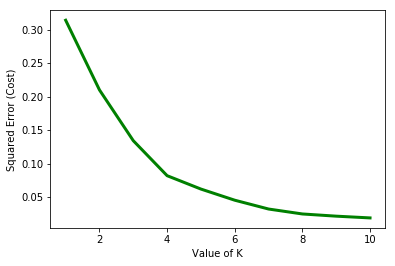

In [311]:
# We use the above dataframe without the "Neighborhood" attribute. 
km_london_grouped = london_grouped.drop(['Neighborhood'], axis=1)

import matplotlib.pyplot as plt 

# Now we will try different values of k and plot the MSE in function of k. Let's find the optimal vlaue of k. 
cost =[] 
for i in range(1,11): 
    km = KMeans(n_clusters = i, max_iter = 500) 
    km.fit(km_london_grouped) 
      
    # calculates squared error for the clustered points 
    cost.append(km.inertia_)      
  
#plot the cost against K values 
plt.plot(range(1,11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k

The optimal value for k corresponds to the elbow of the curve. This means that **the best value is k = 4**. 

In [312]:
# We now apply the algorithm with k=4. 

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(km_london_grouped)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 1, 2, 1, 1, 2, 1, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster for each neighborhood.

In [313]:
# add clustering labels 
london_merged = df
london_merged.insert(0,'Cluster Labels', kmeans.labels_)

london_merged.head() 

,Cluster Labels,Location,London borough,Latitude,Longitude
0,2,Abbey Wood,"Bexley, Greenwich [7]",51.487621,0.114050
1,3,Acton,"Ealing, Hammersmith and Fulham[8]",51.508140,-0.273261
2,1,Aldgate,City[10],51.514248,-0.075719
3,2,Anerley,Bromley[11],51.407599,-0.061939
4,1,Angel,Islington[8],51.531842,-0.105714


Now let's visualize the clusters on a folium map :



In [314]:
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

london_merged_nonan = london_merged.dropna(subset=['Cluster Labels'])

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged_nonan['Latitude'], london_merged_nonan['Longitude'], london_merged_nonan['Location'], london_merged_nonan['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's get the top 10 venues for each neighborhoods in order to better understand the different clusters that have been formed.

In [315]:
london_grouped_top10 = london_onehot.groupby('Neighborhood').mean().reset_index()
print(london_grouped_top10.shape)
london_grouped_top10.head()

(252, 410)


,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Football Field,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Housing Development,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recrea

In [316]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [317]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped_top10['Neighborhood']

for ind in np.arange(london_grouped_top10.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped_top10.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Grocery Store,Convenience Store,Platform,Campground,Coffee Shop,Farm,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space
1,Acton,Pub,Gym / Fitness Center,Grocery Store,Coffee Shop,Hotel,Brewery,Bakery,Basketball Court,Middle Eastern Restaurant,Supermarket
2,Aldgate,Hotel,Coffee Shop,Gym / Fitness Center,Pub,French Restaurant,Restaurant,Cocktail Bar,Korean Restaurant,Garden,Beer Bar
3,Anerley,Train Station,Grocery Store,Hardware Store,Supermarket,Fast Food Restaurant,Gastropub,Park,Tram Station,Convenience Store,Hotel
4,Angel,Pub,Coffee Shop,Mediterranean Restaurant,French Restaurant,Gym / Fitness Center,Bar,Café,Pizza Place,Arts & Crafts Store,Burger Joint


In [318]:
#Let's add the cluster labels to the above dataframe. 
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Abbey Wood,Grocery Store,Convenience Store,Platform,Campground,Coffee Shop,Farm,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space
1,3,Acton,Pub,Gym / Fitness Center,Grocery Store,Coffee Shop,Hotel,Brewery,Bakery,Basketball Court,Middle Eastern Restaurant,Supermarket
2,1,Aldgate,Hotel,Coffee Shop,Gym / Fitness Center,Pub,French Restaurant,Restaurant,Cocktail Bar,Korean Restaurant,Garden,Beer Bar
3,2,Anerley,Train Station,Grocery Store,Hardware Store,Supermarket,Fast Food Restaurant,Gastropub,Park,Tram Station,Convenience Store,Hotel
4,1,Angel,Pub,Coffee Shop,Mediterranean Restaurant,French Restaurant,Gym / Fitness Center,Bar,Café,Pizza Place,Arts & Crafts Store,Burger Joint


Finally let's examine the different clusters that were formed :

In [323]:
#Cluster 0
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 0, neighborhoods_venues_sorted.columns[list(range(1, neighborhoods_venues_sorted.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
66,Earlsfield,Pub,Grocery Store,Thai Restaurant,Gym,Coffee Shop,Cocktail Bar,Café,Indoor Play Area,Italian Restaurant,Lounge
97,Hanwell,Pub,Café,Coffee Shop,Bus Stop,Gym,Fish & Chips Shop,Pizza Place,Supermarket,Hotel,Music Store
102,Highams Park,Gym,Coffee Shop,Indian Restaurant,Martial Arts School,Pub,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space
111,Hornsey,Pub,Gym,French Restaurant,Tapas Restaurant,Grocery Store,Train Station,Trail,Bakery,Bar,Light Rail Station
127,Lewisham,Clothing Store,Pub,Gym,Grocery Store,Coffee Shop,Fast Food Restaurant,Supermarket,Pharmacy,Gym / Fitness Center,Platform
143,Millwall,Grocery Store,Convenience Store,Pub,Supermarket,Bar,Gym,Chinese Restaurant,Indian Restaurant,Bubble Tea Shop,Dim Sum Restaurant
145,Mottingham,Convenience Store,Train Station,Fish & Chips Shop,Gym,Pet Store,Café,Motorcycle Shop,Chinese Restaurant,Pub,Fish Market
152,Norbury,Grocery Store,Ice Cream Shop,Gym,Pub,IT Services,River,Platform,Pizza Place,Coffee Shop,Pharmacy
159,Old Oak Common,Brazilian Restaurant,Platform,Bus Station,Modern European Restaurant,Canal,Gym,Train Station,Dance Studio,Cuban Restaurant,Exhibit
170,Plaistow,Rugby Pitch,Gym,Bus Station,Park,Metro Station,Asian Restaurant,Coffee Shop,Fried Chicken Joint,Fast Food Restaurant,Pub


In [324]:
#Cluster 1 
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 1, neighborhoods_venues_sorted.columns[list(range(1, neighborhoods_venues_sorted.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Aldgate,Hotel,Coffee Shop,Gym / Fitness Center,Pub,French Restaurant,Restaurant,Cocktail Bar,Korean Restaurant,Garden,Beer Bar
4,Angel,Pub,Coffee Shop,Mediterranean Restaurant,French Restaurant,Gym / Fitness Center,Bar,Café,Pizza Place,Arts & Crafts Store,Burger Joint
5,Archway,Pub,Grocery Store,Coffee Shop,Café,Pizza Place,Wine Shop,Italian Restaurant,Indian Restaurant,Tapas Restaurant,Gastropub
7,Bankside,Coffee Shop,Pub,Hotel,Gym / Fitness Center,Seafood Restaurant,Restaurant,Art Museum,Italian Restaurant,Bar,Asian Restaurant
8,Barbican,Food Truck,Coffee Shop,Pub,Gym / Fitness Center,French Restaurant,Hotel,Vietnamese Restaurant,Plaza,Wine Bar,Art Gallery
11,Bayswater,Pub,Hotel,Coffee Shop,Chinese Restaurant,Pizza Place,Persian Restaurant,Garden,Burger Joint,Café,Gym / Fitness Center
16,Blackfriars,Coffee Shop,Pub,Hotel,Scenic Lookout,Restaurant,Falafel Restaurant,Wine Bar,Cocktail Bar,Art Museum,Plaza
19,Blackwall,Hotel,Coffee Shop,Sandwich Place,Gym / Fitness Center,Italian Restaurant,Bus Stop,Grocery Store,Beer Bar,Bakery,Café
20,Bloomsbury,Coffee Shop,Café,Bookstore,Park,Pub,Garden,Plaza,Italian Restaurant,History Museum,Hotel
27,Bromley,Clothing Store,Coffee Shop,Pub,Portuguese Restaurant,Burger Joint,Bar,Supermarket,Pizza Place,Gym / Fitness Center,Gelato Shop


In [325]:
#Cluster 2
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 2, neighborhoods_venues_sorted.columns[list(range(1, neighborhoods_venues_sorted.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Grocery Store,Convenience Store,Platform,Campground,Coffee Shop,Farm,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space
3,Anerley,Train Station,Grocery Store,Hardware Store,Supermarket,Fast Food Restaurant,Gastropub,Park,Tram Station,Convenience Store,Hotel
6,Arnos Grove,Grocery Store,Yoga Studio,Bus Stop,Fish & Chips Shop,Beer Bar,Park,Chinese Restaurant,Dance Studio,Filipino Restaurant,Cycle Studio
9,Barnsbury,Pub,Café,Gastropub,Grocery Store,Park,Bar,Supermarket,Caucasian Restaurant,Ethiopian Restaurant,Coffee Shop
10,Battersea,Pub,Bus Stop,Bakery,Hotel,Park,Italian Restaurant,Café,Thai Restaurant,Bar,Lebanese Restaurant
12,Belgravia,Hotel,Boutique,Italian Restaurant,Restaurant,Plaza,Gastropub,Coffee Shop,Garden,Bakery,French Restaurant
13,Belsize Park,Café,Italian Restaurant,Coffee Shop,Pub,Hotel,Bakery,Pharmacy,Convenience Store,Food & Drink Shop,Pizza Place
14,Bermondsey,Grocery Store,Pub,Brewery,Beer Bar,Café,Bus Stop,Coffee Shop,Park,Farmers Market,Gelato Shop
15,Bethnal Green,Coffee Shop,Pub,Café,Cocktail Bar,Hotel,Flower Shop,Art Gallery,Brewery,Beer Bar,Park
17,Blackheath,Pub,Bakery,Café,Pizza Place,Restaurant,Tapas Restaurant,Park,Gastropub,Greek Restaurant,Bar


In [326]:
#Cluster 3
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 3, neighborhoods_venues_sorted.columns[list(range(1, neighborhoods_venues_sorted.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acton,Pub,Gym / Fitness Center,Grocery Store,Coffee Shop,Hotel,Brewery,Bakery,Basketball Court,Middle Eastern Restaurant,Supermarket
48,Colindale,Gym / Fitness Center,Supermarket,Chinese Restaurant,Bus Stop,Pub,Fast Food Restaurant,Park,Metro Station,Pizza Place,Coffee Shop
63,Dulwich,Park,Farm,Art Gallery,Café,Rugby Pitch,Tennis Court,Gastropub,Gym / Fitness Center,Flower Shop,Restaurant
74,Finchley,Gym / Fitness Center,Bus Stop,Persian Restaurant,Pizza Place,Bakery,Fast Food Restaurant,Grocery Store,Fish Market,Fish & Chips Shop,Food Court
85,Gospel Oak,Gym / Fitness Center,Pub,Café,Mediterranean Restaurant,Gastropub,Italian Restaurant,Convenience Store,Coffee Shop,Farmers Market,Farm
126,Leamouth,Coffee Shop,Gym / Fitness Center,Sandwich Place,Park,Rock Club,Harbor / Marina,Platform,Light Rail Station,Movie Theater,Gym Pool
131,Little Ilford,Gym / Fitness Center,Grocery Store,Park,Gas Station,Farm,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
196,Southgate,Gym / Fitness Center,Pub,Park,Café,Steakhouse,Spanish Restaurant,Fast Food Restaurant,Lounge,Grocery Store,Lebanese Restaurant


## Results 

**We can see that Cluster 0 contains neighborhoods with some gyms, whereas Cluster 1 contains neighborhoods with a few fitness centers or gyms. Cluster 2 regroups all the neighborhoods with no gyms or fitness centers. Finally, Cluster 3 is constituted of neighborhoods with many fitness centers.**

**Let's recall that there is a difference between a gym and a fitness center. Indeed, a fitness center is generally larger than an average gym and provides a wider range of services (outdoor activities are often available, sometimes there are swimming pools...)**

**By examining the last folium map, we notice that the very heart of London is composed of neighborhoods belonging to Cluster 2 (in green). Just beyond the capital's heart, most of the neighborhoods belong to Cluster 1 (in purple). Finally, at the borders of the city, we can find the neighborhoods belonging to Cluster 3 (in yellow) and 0 (in red). This organization in "circular layers" can be explained by different factors but mainly because of the lack of space in the heart of the city, which pushes investors to establish gyms in places with more space and where property prices are lower.**